# TRANSFERENCIA DE APRENDIZAJE, APLICANDO ESTILOS DE ARTISTAS A FOTOS Y PINTURAS

## Transferencia de aprendizaje para transferir el estilo de artistas a fotografías.
¿Qué es un estilo?
"Llamamos estilo a un conjunto de rasgos o signos visuales que caracterizan a una imagen, objeto u obra artística."
http://destinoaitaca.blogspot.com/p/blog-page_11.html

"En las artes visuales, el estilo es una «… manera distintiva que permite la agrupación de obras en categorías relacionadas» o «… cualquier forma distintiva, y por lo tanto reconocible, en la que se realiza un acto o un artefacto hecho o debería ser ser realizado y hecho «. Se refiere a la apariencia visual de una obra de arte que la relaciona con otras obras del mismo artista o del mismo período, entrenamiento, ubicación, «escuela», movimiento de arte o cultura arqueológica: «La noción de estilo ha sido durante mucho tiempo el principal modo del historiador del arte de clasificar las obras de arte. Por estilo, selecciona y da forma a la historia del arte «."
https://www.hisour.com/es/art-style-36070/
https://www.reprodart.com/a/estilos-artisticos.html
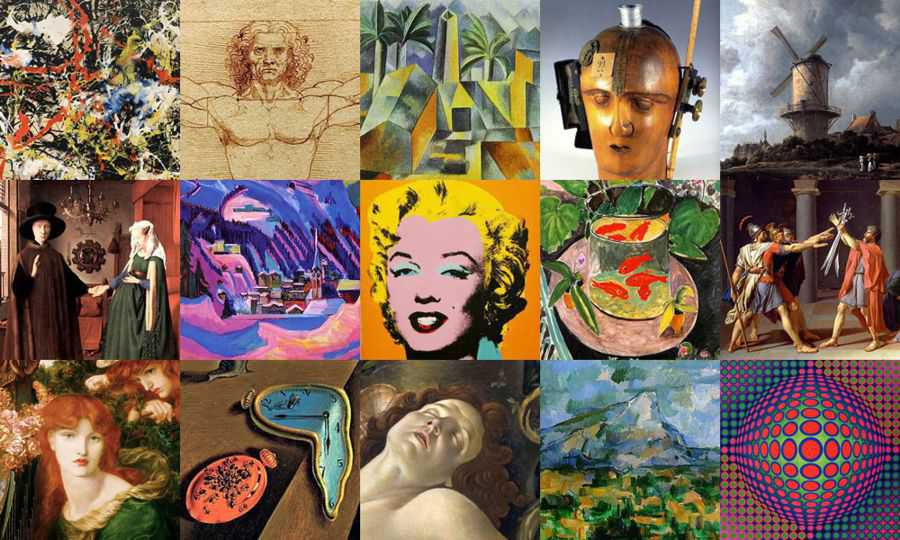


https://blogs.nvidia.com/blog/2019/02/07/what-is-transfer-learning/

In [1]:
# Librerias
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19
import matplotlib.pyplot as plt

2023-08-27 02:14:31.405317: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-27 02:14:32.316931: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-27 02:14:32.317012: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-27 02:14:32.317023: W 

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

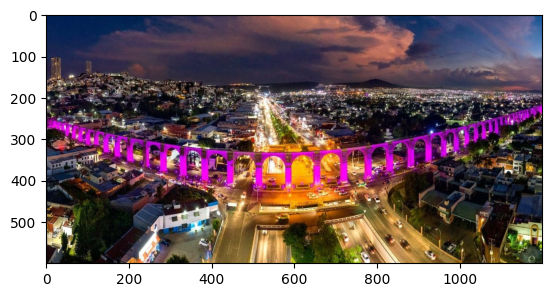

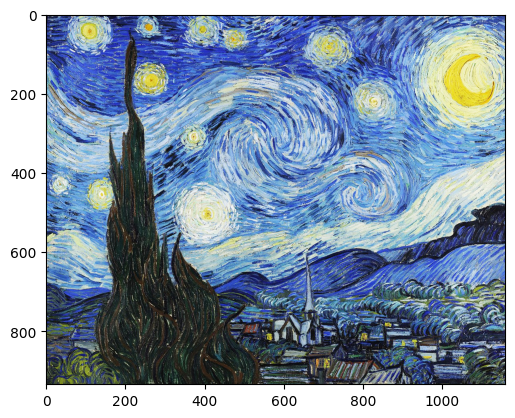

In [3]:
# Cargar las imagenes base y de estilo, 
# Las imagenes pueden tener cualquier tamaño
from PIL import Image

base_path = "Dataset/qro1.jpg"
estilo_path = "Dataset/noche_estrellada.jpg"
base = Image.open(base_path)
estilo = Image.open(estilo_path)

plt.imshow(base)
plt.show()

plt.imshow(estilo)
plt.show()

In [4]:
# Tratamiento de las imagenes y su propiedades
result_prefix = "qro_vanGogh"

# Pesos de los componentes de las perdidas
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

# Dimensiones de la imagen generada
# Proporcionales a la imagen base
width, height = base.size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

In [5]:
def preprocess_image(image_path):
    # Convierte las imagenes en el formato necesario para procesarlas, ademas de convertirlas en tensores
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x):
    # Convirte el tensor resultante en un formato mas como para las imagenes
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [6]:
# Matriz Gram de una imagen tensor (obtención de características): 

def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

# Se diseña para mantener una "pérdida en estilo" o "style loss" 
# del estilo obtenido de la imagen referencia para aplicarlo en la imagen generada
# Esto se obtiene mediante la matriz de Gram (Que captura el estilo) del mapa de
# características obtenidas del estilo de la imagen de referencia y la imagen generada
# es decir, se usa un estilo de discriminador


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))


# An auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))


# The 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent


def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

## Se construye un modelo VGG19 cargado con pesos ImageNet Pre entrenados
## Definición de ImageNet:
ImageNet es el conjunto de datos (Dataset) por excelencia en la actualidad para evaluar algoritmos de clasificación, localización y reconocimiento de imágenes.
ImageNet es una enorme base de datos con más de 14 millones de imágenes etiquetadas en más de 1000 clases, a partir de 2014. En 2007, una investigadora llamada Fei-Fei Li empezó a trabajar en la idea de crear un conjunto de datos de este tipo.

## Definición VGG19:
La VGG19 es una red neuronal convolucional de la familia VGG16 y la diferencia global es que esta red cuenta con 19 capas, de las cuales 16 capas son filtros convolucionales y 3 densas completamente conectadas.
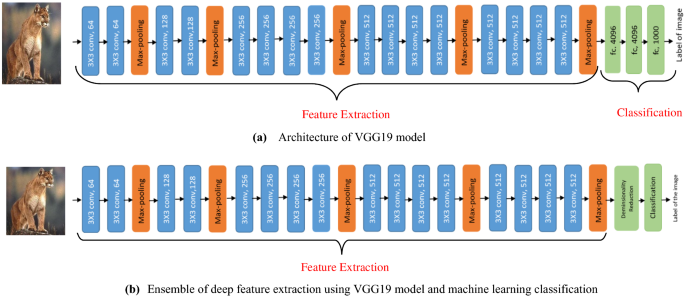

In [7]:
# Se construye un modelo VGG19 cargado con pesos ImageNet Pre entrenados
model = vgg19.VGG19(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

2023-08-27 02:14:34.636034: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-27 02:14:34.636065: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-27 02:14:34.636087: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-nb-aslunaga-0): /proc/driver/nvidia/version does not exist
2023-08-27 02:14:34.636298: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [8]:
# List of layers to use for the style loss.
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# The layer to use for the content loss.
content_layer_name = "block5_conv2"


def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Inicializar las perdidas
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

In [9]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

In [ ]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_path)
style_reference_image = preprocess_image(estilo_path)
combination_image = tf.Variable(preprocess_image(base_path))

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 2000 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.preprocessing.image.save_img(fname, img)

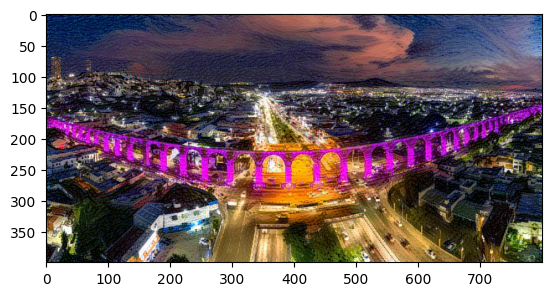

qeo_vanGogh_at_iteration_50.png
960000


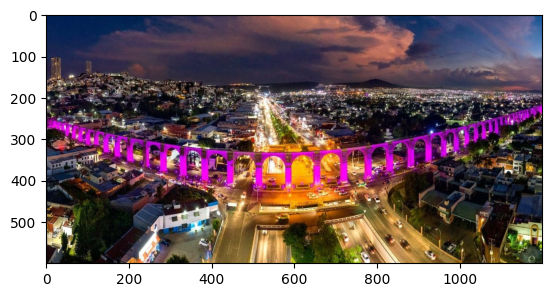

qeo_vanGogh_at_iteration_50.png
960000


In [12]:
plt.imshow(img)
plt.show()
print(fname)
print(img.size)
plt.imshow(base)
plt.show()
print(fname)
print(img.size)